In [12]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import rice, foldnorm
from dw_tools      import dag_pgm_tools, draw_tree
import networkx as nx
import reciprocalspaceship as rs
import gemmi

In [2]:
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

## Taking a "tree" point of view...
Consider three complex structure factors $F_1$,$F_2$,$F_3$, such that 
<img src="img/F1_F2_F3.png" alt="drawing" width="200"/>
for example
<img src="img/friedel_2.png" alt="drawing" width="250"/>

with arrows indicating statistical dependence, parameterized by a DW parameter indicated by the superscripts (note that correlations are equal in both directions). With this scheme, the graph has the structure of a directed acyclic graph (DAG).

For the remainder, we will assume that the structure factors live on a common scale set by $\Sigma=\mathbb{E}(|F|^2)$. To indicate this, we'll switch from $F$ to $E$. We'll keep the common scale $\Sigma$ around, noting that for normalized structure factors $\Sigma=1$.

We can think of $E_2$ as consisting of 
- a chunk depending on $E_1$ with magnitude $r E_1$ and variance $r^2 \frac{\Sigma}{2}$ for real and imag components and,
- an independent bivariate normal chunk $\Delta_{21}$ with mean $(0,0)$ and covariance matrix $\frac{1}{2}(1-r^2)\Sigma \mathbf{I}$, 

with $\mathbf{I}$ the identity matrix. Now, $Var(E_{2x})=r^2 \frac{\Sigma}{2}+\frac{\Sigma}{2}(1-r^2)=\frac{\Sigma}{2}$, as we would expect since $Var(|E|) = Var(E_{2x}) + Var(E_{2y}) = \Sigma$.

### Factorizing the joint probability
The exciting thing about this formalism is that now 

$$
P\left(E_1,E_2,E_3\right) = 
P\left(E_3\bigr| E_2\right)\cdot
P\left(E_2\bigr| E_1\right) P\left(E_1\right)
=
P\left(R_3,\phi_3\bigr| R_2,\phi_2\right)\cdot
P\left(R_2,\phi_2\bigr| R_1,\phi_1\right)\cdot P\left(R_1,\phi_1\right)
$$

with $E_i$ described by its amplitude and phase, $(R_i,\phi_i)$. 

We already know that in the DW model $P\left(R_3,\phi_3\bigr| R_2, \phi_2\right)=P\left(R_3,\Delta\phi_{32}=\phi_3-\phi_2\bigr| R_2\right)$, etc.. That is, only the phase difference matters for the probability, not the specific value of $\phi_2$. We now have:

$$
P\left(E_2,E_3\bigr|E_1\right) = 
P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
$$

so, when we integrate over the unknown phase differences, we get for the amplitudes:

\begin{equation}
P\left(R_2,R_3\bigr|E_1\right) = \int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
                                 \int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
\tag{1a}                                
\end{equation}


The results of _both_ integrals are Rice distributions. 

In our example, 

$$
\int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right) = Rice\left(\nu = r_x R_2, \sigma^2 = \frac{\Sigma}{2}(1-r_x^2)\right)
\tag{1b}  
$$
and
$$
\int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) = Rice\left(\nu = r R_1, \sigma^2 = \frac{\Sigma}{2}(1-r^2)\right)
\tag{1c}  
$$


#### Comparison to sampled data
Let's first examine this example by making a comparison to surrogate data. As described in 8_DAG_PGM_structure_factor_distributions, we can calculate the joint distribution of the real and imaginary components of $E_2$ and $E_3$ _conditional on $E_1$_ using the properties of the multivariate normal (https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions).

For simplicity, we assume $E_1$ is real and has a value of 1.5, as currently written.

In [3]:
rng  = default_rng()
r    = 0.9
rx   = 0.95
R1   = np.asarray([1.5,1.5,0,0])       # unconditional: value of R1 (organized as E_1x,E_1x,E_1y,E_1y)
mean = np.array([r,r*rx,r,r*rx])*R1    # conditional means of components of E2 and E3
cov  = 0.5*\
    np.asarray([[ 1-r**2    , rx*(1-r**2),  0,           0          ],\
                [rx*(1-r**2), 1-rx**2*r**2, 0,           0          ],\
                [0,           0,            1 -r**2,     rx*(1-r**2)],\
                [0,           0,            rx*(1-r**2), 1-rx**2*r**2]])

In [4]:
n_samples = 10000000
vals   = rng.multivariate_normal(mean,cov,n_samples)
R2_sq  = vals[:,0]**2 + vals[:,2]**2
R3_sq  = vals[:,1]**2 + vals[:,3]**2
R2_abs = np.sqrt(R2_sq)
R3_abs = np.sqrt(R3_sq)

In [ ]:
E_2x_sampled = r*   R1[0] + np.sqrt(0.5*(1-r**2)      )*np.random.normal(size=(n_samples,))
E_3x_sampled = r*rx*R1[1] + np.sqrt(0.5*(1-r**2*rx**2))*np.random.normal(size=(n_samples,))
E_2y_sampled = r*   R1[2] + np.sqrt(0.5*(1-r**2)      )*np.random.normal(size=(n_samples,))
E_3y_sampled = r*rx*R1[3] + np.sqrt(0.5*(1-r**2*rx**2))*np.random.normal(size=(n_samples,))

We can now implement eqs. 1a-c and compare to the sampled surrogate data.

In [5]:
def bivariate_Rice_DAG(R1, R2, R3, Sigma=1, r=0.9, rx=0.99):
    cond_mean_21 = (R1 * r)
    cond_mean_32 = (R2 * rx)
    nu_21        = cond_mean_21
    nu_32        = cond_mean_32
    cond_var_21  = 0.5*Sigma*(1-r**2 )
    cond_var_32  = 0.5*Sigma*(1-rx**2)
    sigma_ac_21  = np.sqrt(cond_var_21)
    sigma_ac_32  = np.sqrt(cond_var_32)
    b_21         = nu_21/sigma_ac_21
    b_32         = nu_32/sigma_ac_32
    scale_21     = sigma_ac_21
    scale_32     = sigma_ac_32

    return rice.pdf(R3, b=b_32, scale=scale_32)*rice.pdf(R2, b=b_21, scale=scale_21)

Let's calculate this PDF on a grid.

In [6]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
print(xx.shape)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = bivariate_Rice_DAG(R1[0], y_in[:,0].reshape(1,-1), y_in[:,1].reshape(1,-1), Sigma=1, r=r, rx=rx)
result = result.reshape(nx,ny)
print(result.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
(200, 300)
Elapsed time: 0.0147 s
Integrated probability density: 0.992


We will also compare to the general solution implemented in ```dag_pgm_tools.RiceWoolfson_for_DAG``` and explained in **8_DAG_PGM_structure_factor_distributions**. To be able to do so, we need to summarize the properties of the graph underlying the PGM. Specifically,

In [7]:
list_of_nodes = [0,1,2]
list_of_edges = [(0,1),(1,2)]
root          = 0
list_of_rDW   = [r,rx]  # one element per edge
root_R        = R1[0]   # if we condition on the value of the root, we need to add this. 
                        # For unconditional PDF, use root_R=None

In [8]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(xx.shape)
print(y_in.shape)

t1_start = perf_counter()  
result_2 = dag_pgm_tools.RiceWoolfson_for_DAG(list_of_nodes, list_of_edges, root=root, list_of_rDW=list_of_rDW, \
                                              root_R=root_R, root_rDW=None, Sigma=1, centric=False\
                                             ).prob(np.concatenate((np.zeros((y_in.shape[0],1)), y_in),axis=1))
result_2 = result_2.reshape(nx,ny)
# print(result_2.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result_2[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
Overwrote the 0th column with the reference.
Elapsed time: 0.0236 s
Integrated probability density: 0.992


Let's compare the bivariate and general PDFs to the samples:

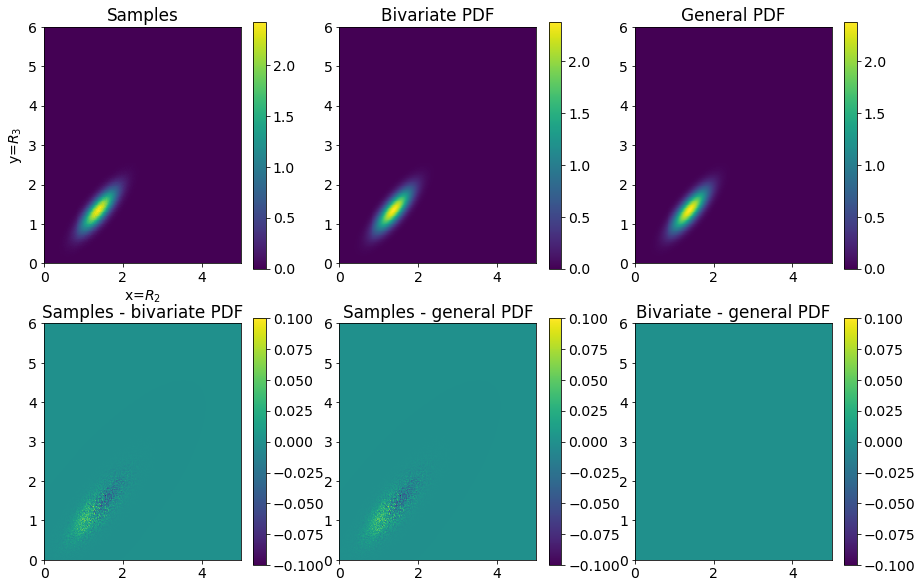

In [10]:
(xmax,ymax) = (x_max,y_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(R2_abs, R3_abs, bins=(xedges, yedges),density=True)

# Since the axes of these plots drive me a nuts, a positive control using [yplot.hist2d.
# In addition, I made the 2D histograms below asymmetric in dimension (remove "extent=[]" to see that),
# and validated labels using 1D histograms above.
# fig,ax=plt.subplots()
# ax.hist2d(R2_abs, R3_abs,bins=50,range=[[0,xmax],[0,ymax]])
# ax.set_aspect('equal')
# ax.set_xlabel(r"$R_2$"); ax.set_ylabel(r"$R_3$")
# plt.show()

plt.figure(figsize=(15,10))                         
plt.subplot(2,3,1)        
plt.imshow(Hx_emp.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) 
plt.xlabel(r"x=$R_2$"); plt.ylabel(r"y=$R_3$")
plt.title("Samples"); plt.colorbar(); 

plt.subplot(2,3,2)        
plt.imshow(result.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("Bivariate PDF"); plt.colorbar()

plt.subplot(2,3,3)        
plt.imshow(result_2.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("General PDF"); plt.colorbar()

plt.subplot(2,3,4)
plt.imshow((Hx_emp-result).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax], vmin=-0.1, vmax=0.1)
plt.title("Samples - bivariate PDF"); plt.colorbar(); 

plt.subplot(2,3,5)
plt.imshow((Hx_emp-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax], vmin=-0.1, vmax=0.1)
plt.title("Samples - general PDF"); plt.colorbar(); 

plt.subplot(2,3,6)
plt.imshow((result-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax], vmin=-0.1, vmax=0.1)
plt.title("Bivariate - general PDF"); plt.colorbar(); plt.show()

We see that the synthetic data, ```bivariate_Rice_DAG``` and the general function ```dag_pgm_tools.RiceWoolfson_for_DAG.prob()``` yield consistent results and match the sample distribution up to sampling and gridding errors.

## General case (see ```8_DAG_PGM_structure_factor_distributions```)
As we saw in "_Factorizing the joint probability_" for the bivariate case, the results of _both_ integrals are Rice distributions. The above principle generalizes to directed trees. Let's mark the parent of each node $R_i$ as $\mathrm{Pa}(R_i)$; let the "origin" be $R_0$, and refer to the DW parameter for $P\left(R_i \bigr| \mathrm{Pa}(R_i)\right)$ as $r_i$, then,

$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
\tag{2a}
$$

That is, to specify a joint prior, all we need to do is to specify the reference prior (optional!), the tree structure $\left\{\left(i, \mathrm{Pa}(i)\right)\right\}$, and estimates of the $r_i$. In the limit of $r_i\rightarrow 0$, the priors return to the Wilson distribution. 

#### Centric case:
The centric case is entirely analogous:
$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
\tag{2b}
$$

## Priors for variational inference
Equations 2a-b specify the priors for variational inference.

## Variational distributions / surrogate posteriors

In terms of functional forms to use, the simplest thing to do is to extend the use of truncated ($TruncNorm$) or folded normal distributions to the bivariate and multivariate cases. Multivariate extensions of the folded normal are easy to implement yourself. 

However, there is one important question--what kind of covariance structure should we use? I see three possibilities:

1. **No covariance structure**. For example, for the general case, $q\left(\{R_i\}\right)=\prod_i q(R_i)$, with $q(R_i)\sim TruncNorm(\mu_{q_i},\sigma_{q_i})$.
2. **Full covariance structure**. For example, for the general case, $q\left(\{R_i\}\right)=MultiTruncNorm(\mu_{q}, C)$, with $C$ a covariance matrix.
3. **Inherit correlation structure from the prior**. For example, for the general case, $q\left(\{R_i\}\right)=MultiTruncNorm(\mu_{q}, S^T C' S)$, with $S$ a diagonal matrix with fittable standard deviations $S_{ii}=\sigma_{q_i}$ and $C'$ described in Murphy, section 10.2.5 and tested in ```8_DAG_PGM_structure_factor_distributions```.

It is not obvious which of these three is the best approach. I favor (3). It seems to me that the only source of posterior correlations should be the prior and that it therefore makes sense to inherit its correlation matrix. This may be particularly beneficial since the likelihood term of the ELBO is evaluated by sampling $q$ and samples will be more likely to fit the prior well if we use the same correlation structure. A welcome side effect is that we do not increase the number of parameters.

## ELBO

We will use Miller index $h$ and image number $i$. 

Let $t$ be an index over operations that relate the different sets of structure factor amplitudes (e.g. for Friedel mates the identity and inversion operators). For example, for anomalous data $F_{h,t=1} = F_h$ and $F_{h,t=2} = F_{-h}$. More generally, $t$ can be any mapping, whether it is time, on/off, or a symmetry operation, or any combination of those.

Following eq. 1 of the bioRxiv preprint, skipping to the sampling step with samples drawn from the surrogate posterior, we have: 

$$\large
ELBO = \sum_{h,i} \sum_j \sum_t \log L\big(I_{h,i,t} \big| F^2_{h,j,t}\Sigma_{h,i,t,j}, \sigma_{I_{h,i,t}} \big) - 
\sum_{h} \sum_j \log\big(q_h(\{F_{h,j,t}\})\big) - \log\big(P(\{F_{h,j,t}\})\big)
\tag{3}
$$

$\Sigma_{hi}$ also depends on $j$ because we're also sampling from the scale function.

As we've seen above, $P(\{F_{h,j,t}\})$ will generally be a product of Rice distributions (acentric) or product of Folded Normals (centric), for which for each $h, i$ we will need to draw samples with as many dimensions as $t$. $q(\{F_{h,j,t}\})$ will likewise be a multivariate distribution, but we can choose its functional form.

#### Application to the case of anomalous data without a reference
The simplest approach to anomalous data is to use the following PGM:

<img src="img/friedel_1.png" alt="drawing" width="200"/>

where $r$ indicates the expected correlation coefficient among real or imaginary components of the $F_h$ and $F_{-h}$ structure factors.

If we apply eq. 3 in this case, $h$ will run over the reflections in the hemisphere with $h>0\mathrm{, any }\ k, l$.

$t\in \{\mathrm{Id}, \mathrm{Inv}\}$ will map those indices to themselves ($t=1$, $\mathrm{Id}$ the identity operator) and to their Friedel mate ($t=2$, $\mathrm{Inv}$ the inversion operator). That is, $F_{h,t=1} = F_h$ and $F_{h,t=2} = F_{-h}$.

In this case, for $h>0$ and acentric:

$$
P(\{F_{h,j}\})=Rice\left(F_{-h, j}  \ \Bigg|\  \nu = r \cdot F_{h, j}, \sigma^2 = \frac{\Sigma^{prior}_{h}}{2}(1-r^2)\right) \cdot
               Wilson\left(F_{h, j} \ \Bigg| \ \Sigma^{prior}_{h}\right)
$$

where, if we want to estimate normalized structure factor amplitudes, $\Sigma^{prior}_h=1$.

(note that generally, there may be Miller indices which are mapped to themselves under the 

$$\large
ELBO = \sum_{h\geq 0,i} \sum_j \sum_t \log L\big(I_{h,i,t} \big| F^2_{h,j,t}\Sigma_{h,i,t,j}, \sigma_{I_{h,i,t}} \big) - 
\sum_{h} \sum_j \log\big(q_h(\{F_{h,j,t}\})\big) - \log\big(P(\{F_{h,j,t}\})\big)
$$